<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/parameter_estimation/parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyDOE

In [ ]:
pip install geneticalgorithm

In [194]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd  
import sys
from scipy.integrate import odeint
from time import time as clock
import random

In [4]:
# In order to access the package you need to have its path. The path required is the path WHERE that package is soterd, not it path
# sys.path.insert(1, 'd:\\DYNAMICAL SIMULATION\\maestria\\maestria')

In [5]:
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 318 (delta 52), reused 18 (delta 6), pack-reused 203
Receiving objects: 100% (318/318), 9.31 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (137/137), done.


In [6]:
cd maestria

/content/maestria


In [25]:
import utilis.functions as fn
from utilis.models import monod_model, inhibition_model

In [190]:
# Definir parametros 
mu_max = 1.2 # g/L
yxs = 0.2 
ks = 280 # g/L
ypx = 4 
ki = 0.3 # L/g

In [213]:
# Configuramos algoritmo genetico
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.8,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

# I need to move this functions later

In [48]:
def plot_simulated_data(data):
    plt.figure(figsize=(10, 5))
    plt.scatter(data.t, data.x, label = 'biomass')
    plt.scatter(data.t, data.s, label = 'substrate')
    plt.scatter(data.t, data.p, label = 'product')
    plt.xlabel("Time (h)", size = 20)
    plt.ylabel('Concentration (g/L)', size = 20)
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()

In [178]:
def fitness_function_monod(parms):
    mu_max, yxs, ks, ypx = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(monod_model, x0, time, args =(0, mu_max, yxs, ks, ypx,)).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_monod, out)

In [179]:
def fitness_function_inhibition(parms):
    mu_max, yxs, ks, ypx, ki = parms
    # Definir condiciones iniciales 
    x0 = np.array([0.2, 40, 0])
    # Definir tiempo de integracion 
    tf = 60 
    dt = 1 
    time = np.arange(0, tf+dt, dt)
    x, s, p =  odeint(inhibition_model, x0, time, args =(0, mu_max, yxs, ks, ypx, ki, )).T
    out = fn.create_df(time, x, s, p)
    return fn.MSE(data_inhibition, out)

In [180]:
def calculate_stats(params):
    mean_values = np.mean(params, axis=0)
    std_values =  np.std(params, axis=0)
    stats = []
    for i in range(len(mean_values)):
        mean_value = mean_values[i]
        std_value = std_values[i]
        lower = mean_value - 1.96*std_value/np.sqrt(params.shape[0])
        upper = mean_value + 1.96*std_value/np.sqrt(params.shape[0])
        stats.append((mean_value, std_value, lower, upper))

    return stats

In [330]:
def plot_stats(data, real_value, y_label):
        
    mean = np.mean(data)
    confidence_interval = 1.96 * np.std(data) / np.sqrt(len(data))

    # Dibuja la gráfica
    plt.errorbar(1, mean, yerr=confidence_interval, fmt="o", color="red", label="Valor promedio")
    plt.scatter(np.full_like(data, 2), data, label = 'Estimado')
    plt.plot(3, real_value, "o", color="blue", label="Valor real")
    plt.xlim(0, 4)
    plt.xticks([1, 2, 3], ["Valor promedio","Estimado", "Valor real"], size = 10)
    plt.ylabel(y_label, size = 20)
    plt.legend()

# Load data

In [181]:
# Load data 
data_monod = pd.read_csv("data/data_monod.csv")
data_monod.head()

,t,x,s,p
0,0,0.076187,39.510367,-1.594598
1,1,0.217710,39.078642,-0.376261
2,2,0.237686,40.207946,0.409200
3,3,0.432216,39.377534,-0.829929
4,4,0.400163,40.167787,1.338085


In [182]:
# Load data 
data_inhibition = pd.read_csv("data/data_inhibition.csv")
data_inhibition.head()

,t,x,s,p
0,0,0.174614,40.745821,1.081127
1,1,-0.060982,38.007323,-1.422682
2,2,0.087718,40.599858,-1.457520
3,3,0.242266,39.281919,0.688872
4,4,0.256444,40.626491,-0.866604


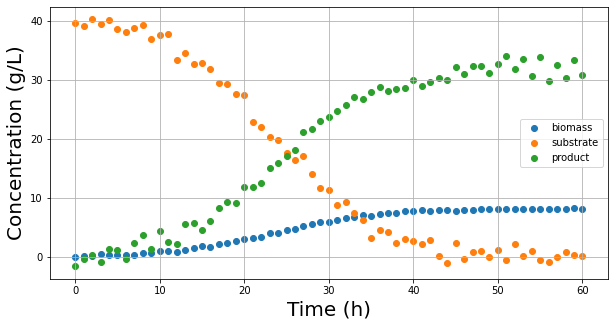

In [183]:
plot_simulated_data(data_monod)

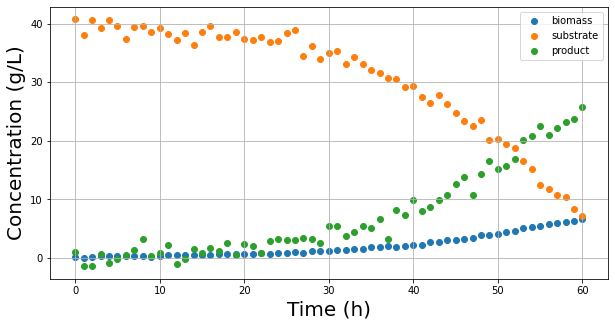

In [184]:
plot_simulated_data(data_inhibition)

In [188]:
fitness_function_monod([mu_max, yxs, ks, ypx])

1.9774320482289816

In [189]:
fitness_function_inhibition([mu_max, yxs, ks, ypx, ki])

2.221335566886478

# Monod

In [214]:
# Establecer los rangos de busqueda para las variables de decision
varbound_monod=np.array([
    [0,3], # mu_max
    [0,1], # yxs
    [100,300], # ks
    [0,10] # ypx
])

In [215]:
model_monod=ga(function=fitness_function_monod,
         dimension=4,
         variable_type='real',
         variable_boundaries=varbound_monod,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.06356492e+00 2.27124379e-01 2.36541125e+02 3.49272459e+00]

 Objective function:
 2.6991456943090615


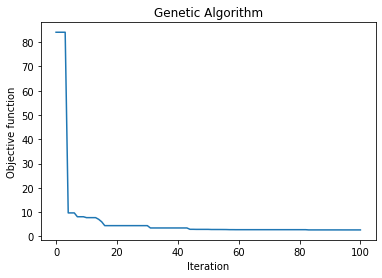

 The best solution found:
 [  0.79530215   0.18826175 178.99425115   4.23926242]

 Objective function:
 2.0968567983633064


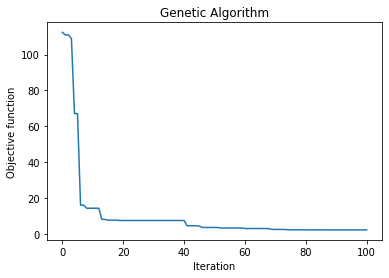

 The best solution found:
 [1.18467917e+00 2.27034578e-01 2.64778188e+02 3.47069026e+00]

 Objective function:
 2.7493492783234688


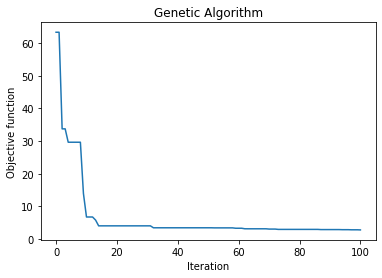

 The best solution found:
 [1.27961163e+00 1.97929547e-01 2.99883809e+02 4.03544857e+00]

 Objective function:
 2.0066220371185604


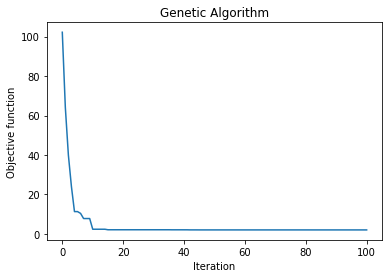

 The best solution found:
 [1.18886072e+00 1.85005592e-01 2.83944402e+02 4.29103269e+00]

 Objective function:
 2.1755569337649905


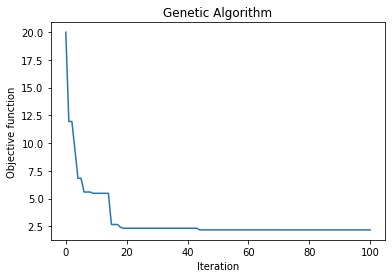

In [216]:
best_function_monod = []
best_values_monod = np.zeros((5, varbound_monod.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(5):
    model_monod.run()
    best_function_monod.append(model_monod.best_function)
    best_values_monod[i,:] = model_monod.best_variable
end_time = clock()

In [217]:
total_time = end_time - start_time
print(f"Total time: {total_time:.3f}s")

Total time: 80.139s


In [218]:
print("Minimun fitness value:")
for best_function in best_function_monod:
    print(best_function)

Minimun fitness value:
2.6991456943090615
2.0968567983633064
2.7493492783234688
2.0066220371185604
2.1755569337649905


In [219]:
print("Average minimum function value:", np.mean(best_function_monod))

Average minimum function value: 2.3455061483758777


In [220]:
print('Best solution found:')
for best_variables in best_values_monod: 
    print(best_variables)

Best solution found:
[1.06356492e+00 2.27124379e-01 2.36541125e+02 3.49272459e+00]
[  0.79530215   0.18826175 178.99425115   4.23926242]
[1.18467917e+00 2.27034578e-01 2.64778188e+02 3.47069026e+00]
[1.27961163e+00 1.97929547e-01 2.99883809e+02 4.03544857e+00]
[1.18886072e+00 1.85005592e-01 2.83944402e+02 4.29103269e+00]


In [221]:
stats_monod = calculate_stats(best_values_monod)

In [222]:
for stats in stats_monod:
    print(stats)

(1.1024037163581515, 0.16820614094768865, 0.9549645331245099, 1.249842899591793)
(0.205071169289385, 0.018465763467697068, 0.18888521396026547, 0.22125712461850455)
(252.82835504126896, 42.52521929136845, 215.55335685258353, 290.1033532299544)
(3.9058317060016905, 0.35675255888663937, 3.5931243006572218, 4.218539111346159)


mu_max = 1.2  g/L

yxs = 0.2 

ks = 280  g/L

ypx = 4 

# Inhibition model

In [223]:
# Establecer los rangos de busqueda para las variables de decision
varbound_inhibition=np.array([
    [0,3], # mu_max
    [0,1], # yxs
    [100,300], # ks
    [0,10], # ypx
    [0, 1] # ki
])

In [224]:
model_inhibition=ga(function=fitness_function_inhibition,
         dimension=5,
         variable_type='real',
         variable_boundaries=varbound_inhibition,
         algorithm_parameters=algorithm_param)

 The best solution found:
 [1.49311141e+00 1.14626466e-01 2.51743689e+02 6.73456126e+00
 6.21721812e-01]

 Objective function:
 3.60719920116721


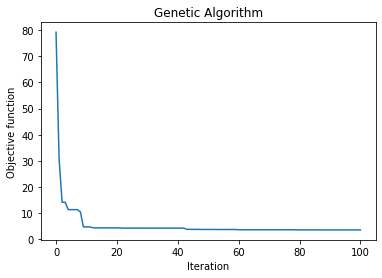

 The best solution found:
 [1.03993145e+00 1.51287248e-01 2.24166260e+02 5.08756893e+00
 3.14283688e-01]

 Objective function:
 2.660325453251373


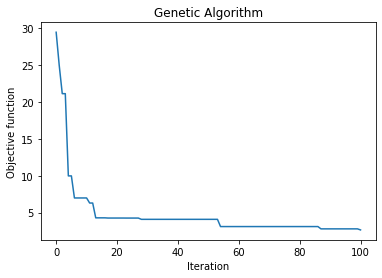

 The best solution found:
 [  0.76876261   0.2589594  151.21279745   3.10293463   0.17899029]

 Objective function:
 3.271611034034637


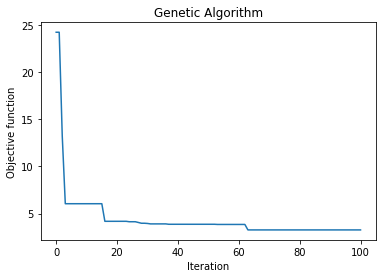

 The best solution found:
 [  0.80258826   0.1827495  179.89128404   4.4842784    0.21043622]

 Objective function:
 2.4078143972048567


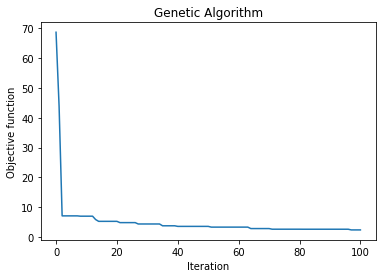

 The best solution found:
 [7.00317961e-01 1.62972418e-01 1.74089861e+02 4.82804687e+00
 1.75822236e-01]

 Objective function:
 2.5716601049903294


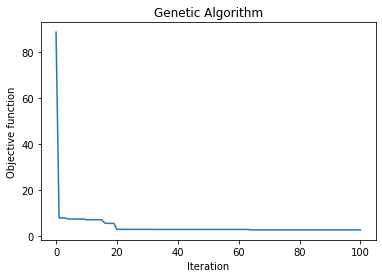

In [225]:
best_function_inhibition = []
best_values_inhibition = np.zeros((5, varbound_inhibition.shape[0]))
# Realizar la busqueda
start_time = clock()
for i in range(5):
    model_inhibition.run()
    best_function_inhibition.append(model_inhibition.best_function)
    best_values_inhibition[i,:] = model_inhibition.best_variable
end_time = clock()

In [226]:
total_time_inhibition = end_time - start_time
print(f"Total time: {total_time_inhibition:.3f}s")

Total time: 73.510s


In [227]:
print("Minimun fitness value:")
for best_function in best_function_inhibition:
    print(best_function)

Minimun fitness value:
3.60719920116721
2.660325453251373
3.271611034034637
2.4078143972048567
2.5716601049903294


In [228]:
print("Average minimum function value:", np.mean(best_function_inhibition))

Average minimum function value: 2.9037220381296813


In [229]:
print('Best solution found:')
for best_variables in best_values_inhibition: 
    print(best_variables)

Best solution found:
[1.49311141e+00 1.14626466e-01 2.51743689e+02 6.73456126e+00
 6.21721812e-01]
[1.03993145e+00 1.51287248e-01 2.24166260e+02 5.08756893e+00
 3.14283688e-01]
[  0.76876261   0.2589594  151.21279745   3.10293463   0.17899029]
[  0.80258826   0.1827495  179.89128404   4.4842784    0.21043622]
[7.00317961e-01 1.62972418e-01 1.74089861e+02 4.82804687e+00
 1.75822236e-01]


In [230]:
stats_inhibition = calculate_stats(best_values_inhibition)

In [231]:
for stats in stats_inhibition:
    print(stats)

(0.9609423388436295, 0.28961261470414873, 0.7070856893446162, 1.2147989883426427)
(0.1741190053759139, 0.04786914527290684, 0.1321598495367412, 0.2160781612150866)
(196.22077828882328, 36.45789839875225, 164.2640213473581, 228.17753523028847)
(4.847478018363491, 1.1657143712355005, 3.8256843204025373, 5.8692717163244446)
(0.3002508496669936, 0.16840057609263184, 0.15264123651443934, 0.4478604628195479)


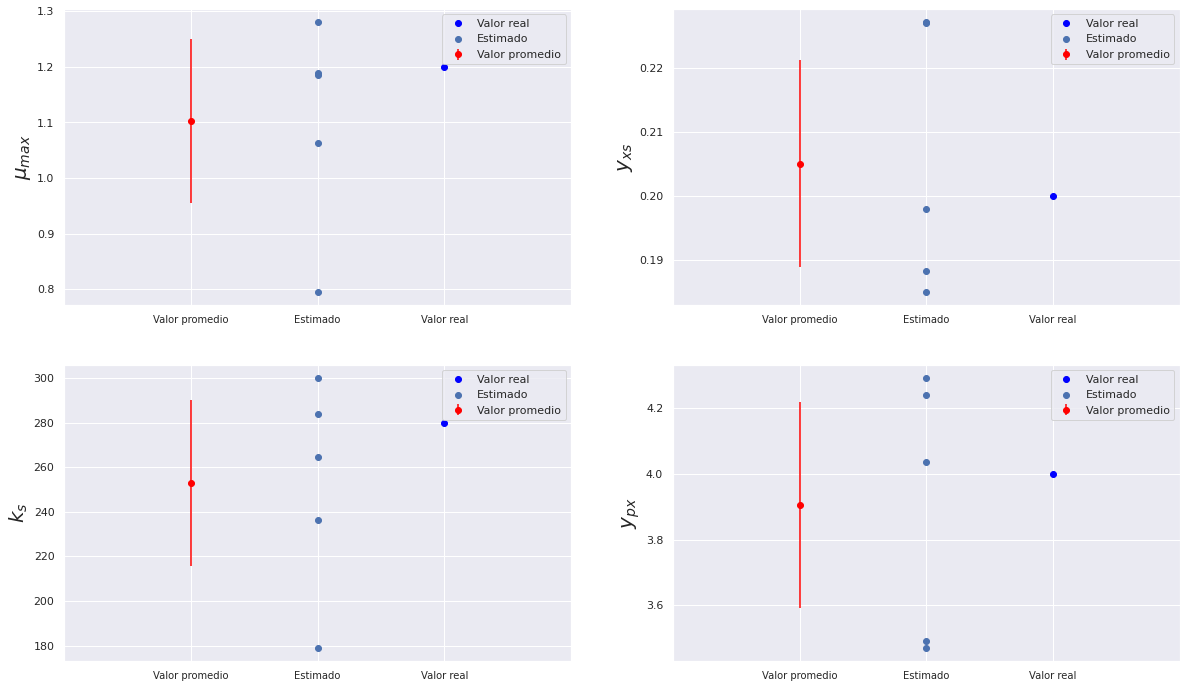

In [334]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_monod[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_monod[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_monod[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_monod[:, 3], ypx, "$y_{px}$")
plt.show()

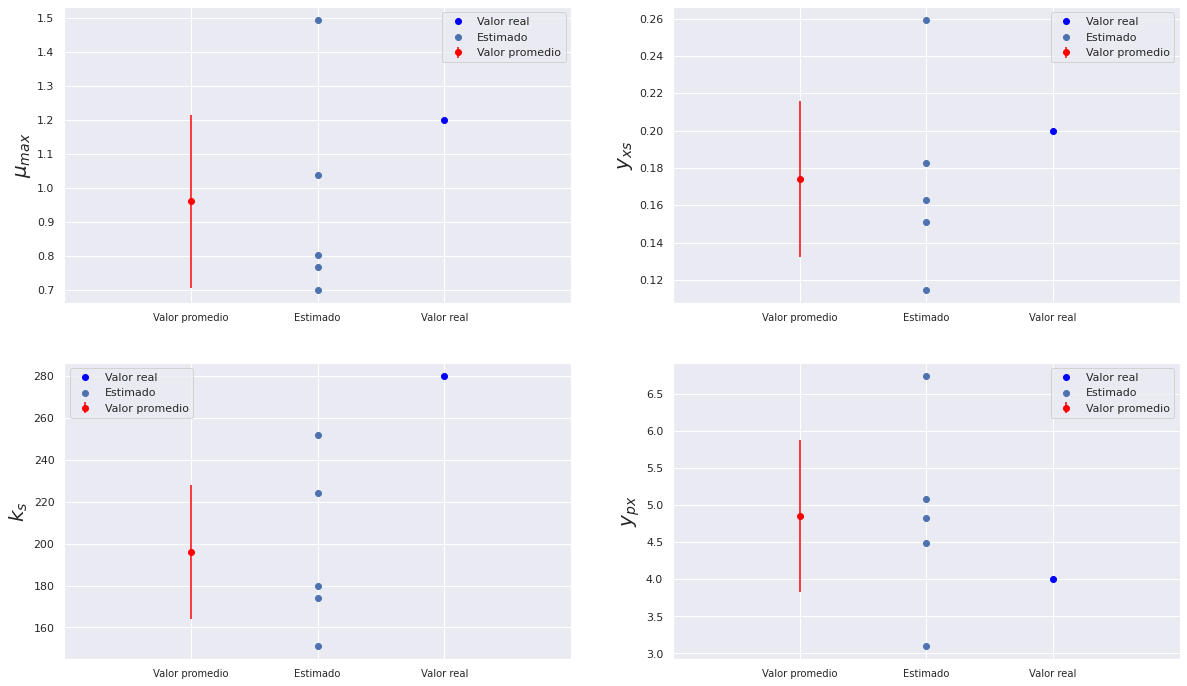

In [335]:
plt.figure(figsize=(20,12))
plt.subplot(2,2, 1)
plot_stats(best_values_inhibition[:, 0], mu_max, "$\mu_{max}$")
plt.subplot(2,2, 2)
plot_stats(best_values_inhibition[:, 1], yxs, "$y_{xs}$")
plt.subplot(2,2, 3)
plot_stats(best_values_inhibition[:, 2], ks, "$k_s$")
plt.subplot(2,2, 4)
plot_stats(best_values_inhibition[:, 3], ypx, "$y_{px}$")
plt.show()

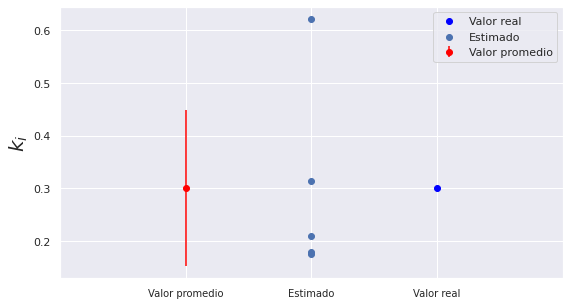

In [340]:
plt.figure(figsize=(9,5))
plot_stats(best_values_inhibition[:, 4], ki, "$k_i$")
plt.show()